In [ ]:
import sys
sys.path.append("/usr/local/Cellar/python\@3.8/3.8.3/bin/python3.8")
import ROOT
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import root_numpy
from root_pandas import read_root
from scipy import stats
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
#/usr/local/Cellar/jupyterlab/2.1.4/libexec/bin/python3.8 -m pip install

In [ ]:
def GetStats(data):
    '''
    Input is a 1D array 
    '''
    N = len(data)
    mean = np.mean(data)
    meanError = stats.sem(data)
    sd = np.std(data)
    sdError = np.sqrt(sd**2/ (2*N) ) # ROOT-style Gaussian error on the sigma https://root.cern.ch/doc/master/TH1_8cxx_source.html#l07111
    return N, mean, meanError, sd, sdError

# define a legend function with good formatting and precision of 4 decimal places
def StatsLegend(N, mean, meanError, sd, sdError, prec=4):
    '''
    form a string from stats inputs with given precision
    '''
    meanS='Mean'
    sigmaS='Std Dev'
    # form raw string with Latex
    #+str(sigmaS)+"={0:.{prec}f}({1:d})".format(sd, int(round(sdE*10**prec)), prec=prec)
    
    legend = ["Entries = {0:d}\n".format(N), \
              "Mean = {0:.{prec}f}$\pm${1:.{prec}f}\n".format(mean, meanError, prec=prec),\
              "Std Dev = {0:.{prec}f}$\pm${1:.{prec}f}\n".format(sd, sdError, prec=prec)
             ]
    legend=''.join(legend)
    return legend

def textL(ax, x, y, legend, font_size=14):
    '''
    return a good formatted plot legend
    '''
    return ax.text(x, y, str(legend),  fontsize=font_size, transform=ax.transAxes, horizontalalignment='left', verticalalignment='center')
def mkdir_p(mypath):
    '''Creates a directory. equivalent to using mkdir -p on the command line'''

    from errno import EEXIST
    from os import makedirs,path

    try:
        makedirs(mypath)
    except OSError as exc: # Python >2.5
        if exc.errno == EEXIST and path.isdir(mypath):
            pass
        else: raise

def ComputeRadialPosition(globalX,globalZ) :
    return np.sqrt(globalX*globalX+globalZ*globalZ)-7112
def ComputeRadialMomentum(azimuth,globalpX,globalpZ) :
    return np.cos(azimuth*np.pi/180)*globalpX + np.sin(azimuth*np.pi/180)*globalpZ
def ComputeAzimuth(globalX,globalZ) :
    return math.atan2(globalZ,globalX)
def nth_bit(number, position):
    return number >> position & 1

In [530]:
#rootPath = '/Users/seanfoster/gitHub/g-2/TrackingAnalysis/TrackerTarget/gm2trackerTargetTree_particle_gun_ana.root'
rootPath = '/Users/seanfoster/gitHub/g-2/TrackingAnalysis/TrackerTarget/gm2trackerTargetTree_muon_beamgun_ana_10587347_1595008785.1.root'
# rootPath = '/Users/seanfoster/gitHub/g-2/TrackingAnalysis/TrackerTarget/combined_trackerTargetTrees.root'
#treePath = '/TrackerTargetTreeNominal/TrackerTargetTreeNominal'
treePath = '/TrackerTargetTreeTrueExtrap/TrackerTargetTreeTrueExtrap'

In [531]:
inputFile = ROOT.TFile(rootPath)
tree = inputFile.Get(treePath)

In [532]:
treeList = []
iTrack = 0
for entry in tree :
    if (iTrack < -10) :
        break
    if (nth_bit(entry.vertexQualityStatus,21) == 0) : #no volumes hit
        
        ghostExitAzimuth = float("NaN")
        ghostExitMomMag = float("NaN")
        ghostExitMomChange = float("NaN")  
        if (len(entry.ghostPlaneAzimuths) > 0) :
            ghostEnterMomMag = np.linalg.norm([entry.ghostPlaneMomXs[0],entry.ghostPlaneMomYs[0],entry.ghostPlaneMomZs[0]])
            ghostExitMomMag = np.linalg.norm([entry.ghostPlaneMomXs[len(entry.ghostPlaneAzimuths)-1],entry.ghostPlaneMomYs[len(entry.ghostPlaneAzimuths)-1],entry.ghostPlaneMomZs[len(entry.ghostPlaneAzimuths)-1]])
            ghostExitMomChange = ghostEnterMomMag - ghostExitMomMag
            for iGhost in range(0,len(entry.ghostPlaneAzimuths)) :
                ghostMomMag = np.linalg.norm([entry.ghostPlaneMomXs[iGhost],entry.ghostPlaneMomYs[iGhost],entry.ghostPlaneMomZs[iGhost]])
                if ( np.abs(ghostMomMag - ghostExitMomMag) < 0.00001) :
                    #assuming that ghostPlaneAzimuths is sorted from small to large
                    ghostExitAzimuth = entry.ghostPlaneAzimuths[iGhost]          
                    break
        
        for iPlane in range(0,len(entry.planeAzimuths)) :  
            #ghost plane stuff
            indices = np.where(np.asarray(entry.ghostPlaneAzimuths)==entry.planeAzimuths[iPlane])
            ghostPlaneActualAzimuth = float("NaN")
            ghostPlaneRadPos = float("NaN")
            ghostPlaneVertPos = float("NaN")
            ghostPlanePosX = float("NaN")
            ghostPlanePosY = float("NaN")
            ghostPlanePosZ = float("NaN")
            ghostPlaneRadMom = float("NaN")
            ghostPlaneVertMom = float("NaN")
            ghostPlaneMomMag = float("NaN")
            if (len(indices[0]) != 0) :
                iGhost = int(indices[0][0])
                ghostPlaneActualAzimuth = entry.ghostPlaneActualAzimuths[iGhost]
                ghostPlaneRadPos = ComputeRadialPosition(entry.ghostPlanePosXs[iGhost],entry.ghostPlanePosZs[iGhost])
                ghostPlaneVertPos = entry.ghostPlanePosYs[iGhost]
                ghostPlanePosX = entry.ghostPlanePosXs[iGhost]
                ghostPlanePosY = entry.ghostPlanePosYs[iGhost]
                ghostPlanePosZ = entry.ghostPlanePosZs[iGhost]
                ghostPlaneRadMom = ComputeRadialMomentum(entry.planeAzimuths[iPlane],entry.ghostPlaneMomXs[iGhost],entry.ghostPlaneMomZs[iGhost])
                ghostPlaneVertMom = entry.ghostPlaneMomYs[iGhost]
                ghostPlaneMomMag = np.linalg.norm([entry.ghostPlaneMomXs[iGhost],entry.ghostPlaneMomYs[iGhost],entry.ghostPlaneMomZs[iGhost]])                    

            treeList.append([
                iTrack,
                entry.passCandidateQuality,
                entry.passTrackQuality,
                entry.passVertexQuality,
                entry.candidateQualityStatus,
                entry.trackQualityStatus,
                entry.vertexQualityStatus,
                entry.pdgID,
                entry.station,
                entry.planeActualAzimuths[iPlane],
                entry.planeAzimuths[iPlane],
                ComputeRadialPosition(entry.planePosXs[iPlane],entry.planePosZs[iPlane]),
                entry.planePosYs[iPlane],
                entry.planePosXs[iPlane],
                entry.planePosYs[iPlane],
                entry.planePosZs[iPlane],
                ComputeRadialMomentum(entry.planeAzimuths[iPlane],entry.planeMomXs[iPlane],entry.planeMomZs[iPlane]),
                entry.planeMomYs[iPlane],
                np.linalg.norm([entry.planeMomXs[iPlane],entry.planeMomYs[iPlane],entry.planeMomZs[iPlane]]),
                ghostPlaneActualAzimuth,
                ghostPlaneRadPos,
                ghostPlaneVertPos,
                ghostPlanePosX,
                ghostPlanePosY,
                ghostPlanePosZ,
                ghostPlaneVertMom,
                ghostPlaneRadMom,
                ghostPlaneMomMag,
                ghostExitAzimuth,
                ghostExitMomMag,
                ghostExitMomChange
             ])
        iTrack += 1

In [533]:
df = pd.DataFrame(treeList)
df.columns = ['TrackNumber','passCandidateQuality','passTrackQuality','passVertexQuality','candidateQualityStatus','trackQualityStatus','vertexQualityStatus','pdgID','station','planeActualAzimuth','planeAzimuth','planeRadPos','planeVertPos','planeXPos','planeYPos','planeZPos','planeRadMom','planeVertMom','planeMomMag','ghostPlaneActualAzimuth','ghostPlaneRadPos','ghostPlaneVertPos','ghostPlaneXPos','ghostPlaneYPos','ghostPlaneZPos','ghostPlaneRadMom','ghostPlaneVertMom','ghostPlaneMomMag','ghostExitAzimuth','ghostExitMomMag','ghostExitMomChange']
print(tree.GetEntries())
print(len(df.TrackNumber.unique()))

79946
27852


In [534]:
useCandidateQuality = 0
useTrackQuality = 1
useVertexQuality = 0
noVolumesHit = 1
includeMuons = 1
includePositrons = 0

applyMomMagHighCut = 0
momMagHighCut = 2600
applyMomMagLowCut = 0
momMagLowCut = 2600
applyRadMomHighCut = 0
radMomHighCut = -60
applyRadMomLowCut =0
radMomLowCut = -40
applyRadPosHighCut = 0
radPosHighCut = 100
applyRadPosLowCut = 0
radPosLowCut = -30
applyMaxNumberOfEntries = 0
maxNumberOfEntries = 100

dfCut = df
if (includePositrons == 1 and includeMuons == 1) :
    dfCut = dfCut.loc[(dfCut['pdgID']==-11) & (dfCut['pdgID']==-13)]
elif (includeMuons == 1) :
    dfCut = dfCut.loc[(dfCut['pdgID']==-13)]
elif (includePositrons == 1) :
    dfCut = dfCut.loc[(dfCut['pdgID']==-11)]
    
if (useCandidateQuality == 1) : 
    dfCut = dfCut.loc[(dfCut['passCandidateQuality']==1)]
if (useTrackQuality == 1) : 
    dfCut = dfCut.loc[(dfCut['passTrackQuality']==1)]
if (useVertexQuality == 1) : 
    dfCut = dfCut.loc[(dfCut['passVertexQuality']==1)]
if (noVolumesHit == 1) :
    dfCut = dfCut.loc[np.array([nth_bit(num,21) for num in dfCut['vertexQualityStatus'].values])==0]
if (applyMomMagHighCut == 1) :
    dfCut = dfCut.loc[(dfCut['planeMomMag']<momMagHighCut)]
if (applyMomMagLowCut == 1) :
    dfCut = dfCut.loc[(dfCut['planeMomMag']>momMagLowCut)]
if (applyRadMomHighCut == 1) :
    dfCut = dfCut.loc[(dfCut['planeRadMom']<radMomHighCut)]
if (applyRadMomLowCut == 1) :
    dfCut = dfCut.loc[(dfCut['planeRadMom']>radMomLowCut)]
if (applyRadPosHighCut == 1) :
    dfCut = dfCut.loc[(dfCut['planeRadPos']<radPosHighCut)]
if (applyRadPosLowCut == 1) :
    dfCut = dfCut.loc[(dfCut['planeRadPos']>radPosLowCut)]
    
#this should be last
if (applyMaxNumberOfEntries) :
    dfCut = dfCut[dfCut['TrackNumber'].isin(dfCut.TrackNumber.unique()[0:maxNumberOfEntries])]
print(len(dfCut))
print(len(df.TrackNumber.unique()))
print(len(dfCut.TrackNumber.unique()))

282906
27852
9126


#### Attempt #1 : Assume that all muons exit that back side of the target. The target is 100mm long, so the back side of the target is 50mm from the center. The center is placed at 160.3 degrees azimuth, so the back side is at 160.3 + 50/7112*180/pi = 160.70 degrees. This is not quite right because of the curvature of the ring, but it is close enough for this first pass.

Radial mean   : -1.55 +/- 0.01 mm
Vertical mean : -0.06 +/- 0.01 mm


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_rad
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_vert
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_2D
Info in <TCanvas::Print>: pdf file Images/Individual/radial.pdf has been created
Info in <TCanvas::Print>: pdf file Images/Individual/vertical.pdf has been created
Info in <TCanvas::Print>: pdf file Images/Individual/2D.pdf has been created


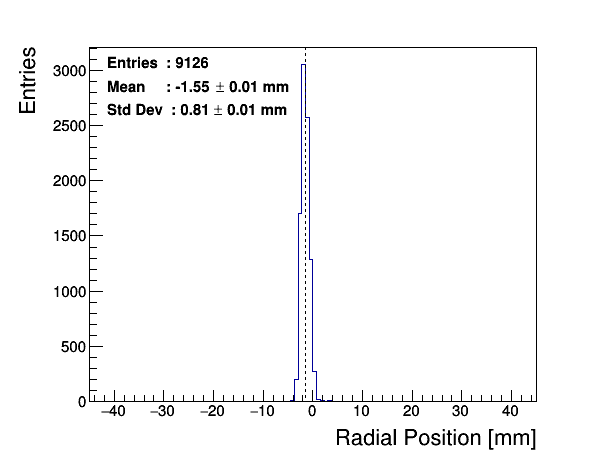

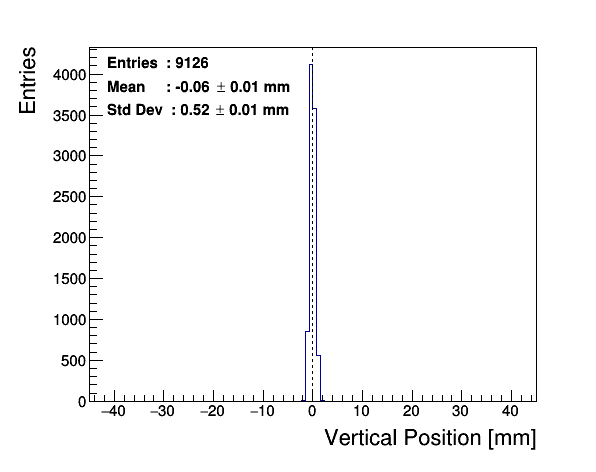

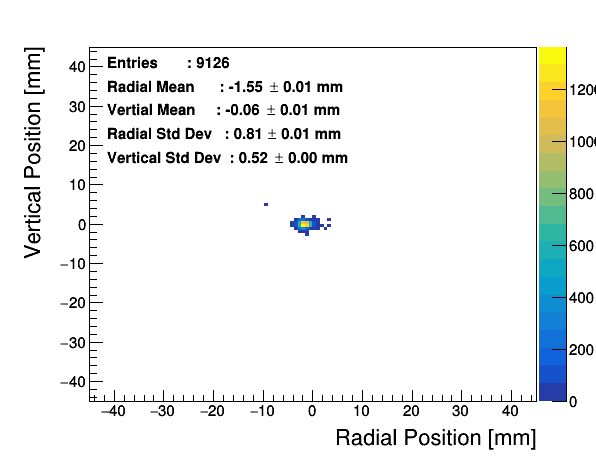

In [535]:
#del c_rad,c_vert,c_2D,h_rad_attempt1,h_vert_attempt1,h_2D_attempt1
ROOT.gStyle.SetOptStat(0)
azimuth = 160.7
low = -45
high = 45
m=nBins = 120

h_rad_attempt1 = ROOT.TH1F("radPos_attempt1","radPos_attempt1",nBins,low,high)
h_vert_attempt1 = ROOT.TH1F("vertPos_attempt1","vertPos_attempt1",nBins,low,high)
h_2D_attempt1 = ROOT.TH2F("2D_attempt1","2D_attempt1",nBins,low,high,nBins,low,high)
    
radPositions = dfCut.loc[(dfCut['planeAzimuth']==azimuth) & (dfCut['planeRadPos'].notnull())]['planeRadPos'].values
vertPositions = dfCut.loc[(dfCut['planeAzimuth']==azimuth)& (dfCut['planeVertPos'].notnull())]['planeVertPos'].values

for i in range(0,len(radPositions)) :
        if ((not math.isnan(radPositions[i])) and (not math.isnan(vertPositions[i]))) :
            h_rad_attempt1.Fill(radPositions[i])
            h_vert_attempt1.Fill(vertPositions[i])
            h_2D_attempt1.Fill(radPositions[i],vertPositions[i])
            
#plot the histograms
c_rad = ROOT.TCanvas("c_rad","Radial Position",600,500)
h_rad_attempt1.Draw()
latex = ROOT.TLatex();
latex.SetTextSize(0.035);
latex.SetTextAlign(13);
latex.DrawLatexNDC(.18,.88,"Entries  : " +  "{:.0f}".format(h_rad_attempt1.GetEntries()));
latex.DrawLatexNDC(.18,.83,"Mean     : " +  "{:.2f}".format(h_rad_attempt1.GetMean()) + " #pm " + "{:.2f}".format(h_rad_attempt1.GetMeanError()) + " mm");
latex.DrawLatexNDC(.18,.78,"Std Dev  : " +  "{:.2f}".format(h_rad_attempt1.GetRMS()) + " #pm " + "{:.2f}".format(h_rad_attempt1.GetRMSError()) + " mm");
h_rad_attempt1.GetXaxis().SetTitleSize(0.05)
h_rad_attempt1.GetYaxis().SetTitleSize(0.05)
c_rad.SetLeftMargin(0.15)
c_rad.SetBottomMargin(0.15)
c_rad.Draw()
lih = ROOT.TLine(h_rad_attempt1.GetMean(),0,h_rad_attempt1.GetMean(),c_rad.GetUymax()) 
lih.SetLineStyle(2)
lih.Draw()
    
c_vert = ROOT.TCanvas("c_vert","Vertical Position",600,500)
h_vert_attempt1.Draw()
latex = ROOT.TLatex();
latex.SetTextSize(0.035);
latex.SetTextAlign(13);
latex.DrawLatexNDC(.18,.88,"Entries  : " +  "{:.0f}".format(h_vert_attempt1.GetEntries()));
latex.DrawLatexNDC(.18,.83,"Mean     : " +  "{:.2f}".format(h_vert_attempt1.GetMean()) + " #pm " + "{:.2f}".format(h_rad_attempt1.GetMeanError()) +" mm");
latex.DrawLatexNDC(.18,.78,"Std Dev  : " +  "{:.2f}".format(h_vert_attempt1.GetRMS()) + " #pm " + "{:.2f}".format(h_rad_attempt1.GetRMSError()) + " mm");
h_vert_attempt1.GetXaxis().SetTitleSize(0.05)
h_vert_attempt1.GetYaxis().SetTitleSize(0.05)
c_vert.SetLeftMargin(0.15)
c_vert.SetBottomMargin(0.15)
c_vert.Draw()
liv = ROOT.TLine(h_vert_attempt1.GetMean(),0,h_vert_attempt1.GetMean(),c_vert.GetUymax()) 
liv.SetLineStyle(2)
liv.Draw()

c_2D = ROOT.TCanvas("c_2D","2D",600,500)
h_2D_attempt1.Draw("colz")
latex = ROOT.TLatex();
latex.SetTextSize(0.035);
latex.SetTextAlign(13);
latex.DrawLatexNDC(.18,.88,"Entries       : " +  "{:.0f}".format(h_2D_attempt1.GetEntries()));
latex.DrawLatexNDC(.18,.83,"Radial Mean      : " +  "{:.2f}".format(h_2D_attempt1.GetMean(1)) + " #pm " + "{:.2f}".format(h_2D_attempt1.GetMeanError(1)) +" mm");
latex.DrawLatexNDC(.18,.78,"Vertial Mean     : " +  "{:.2f}".format(h_2D_attempt1.GetMean(2)) + " #pm " + "{:.2f}".format(h_2D_attempt1.GetMeanError(2)) +" mm");
latex.DrawLatexNDC(.18,.73,"Radial Std Dev   : " +  "{:.2f}".format(h_2D_attempt1.GetRMS(1)) + " #pm " + "{:.2f}".format(h_2D_attempt1.GetRMSError(1)) + " mm");
latex.DrawLatexNDC(.18,.68,"Vertical Std Dev  : " +  "{:.2f}".format(h_2D_attempt1.GetRMS(2)) + " #pm " + "{:.2f}".format(h_2D_attempt1.GetRMSError(2)) + " mm");
h_2D_attempt1.GetXaxis().SetTitleSize(0.05)
h_2D_attempt1.GetYaxis().SetTitleSize(0.05)
c_2D.SetLeftMargin(0.15)
c_2D.SetBottomMargin(0.15)
c_2D.Draw()

# h_rad_attempt1.GetXaxis().SetRangeUser(-10,10)
# h_vert_attempt1.GetXaxis().SetRangeUser(-10,10)
print("Radial mean   : " + "{:.2f}".format(h_rad_attempt1.GetMean()) + " +/- " + "{:.2f}".format(h_rad_attempt1.GetMeanError()) + " mm")
print("Vertical mean : " + "{:.2f}".format(h_vert_attempt1.GetMean()) + " +/- " + "{:.2f}".format(h_vert_attempt1.GetMeanError()) + " mm")
# h_rad_attempt1.GetXaxis().SetRangeUser(-45,45)
# h_vert_attempt1.GetXaxis().SetRangeUser(-45,45)
h_rad_attempt1.SetTitle(";Radial Position [mm];Entries")
h_vert_attempt1.SetTitle(";Vertical Position [mm];Entries")
h_2D_attempt1.SetTitle(";Radial Position [mm];Vertical Position [mm]")

#save
c_rad.SaveAs("Images/Individual/radial.pdf")
c_vert.SaveAs("Images/Individual/vertical.pdf")
c_2D.SaveAs("Images/Individual/2D.pdf")

#### At this point, it is not clear whether we have or have not done the right thing. The question we need to ask is what the expected signal should be given a target at some location in the ring. Let's plot the location of the target in the radial/azimuth and vertical/azimuth planes, to get a better idea of what to expect

In [ ]:
#target locations
alpha=160.3
R0 = 7112
dr = 0.5
dv = 0.5

plt.rc('xtick',labelsize=20)
plt.rc('ytick',labelsize=20)

azLengths = np.linspace(-50,50,100)
rLengths = np.linspace(-0.5,0.5,10)
azInner = []
azOuter = []
azLeft = []
azRight = []
radInner = []
radOuter = []
radLeft = []
radRight = []

rCenter = [R0*np.sin(alpha*np.pi/180),R0*np.cos(alpha*np.pi/180)]
drInner = [-dr*np.sin(alpha*np.pi/180),-dr*np.cos(alpha*np.pi/180)]
drOuter = [+dr*np.sin(alpha*np.pi/180),+dr*np.cos(alpha*np.pi/180)]

for l in azLengths :
    rInner = [rCenter[i] + drInner[i] + [l*np.sin(alpha*np.pi/180-np.pi/2.0),l*np.cos(alpha*np.pi/180-np.pi/2.0)][i] for i in range(len(rCenter))] 
    azInner.append(np.arctan2(rInner[0],rInner[1])*180/np.pi) 
    radInner.append(np.linalg.norm(rInner)-7112)
    
    rOuter = [rCenter[i] + drOuter[i] + [l*np.sin(alpha*np.pi/180-np.pi/2.0),l*np.cos(alpha*np.pi/180-np.pi/2.0)][i] for i in range(len(rCenter))] 
    azOuter.append(np.arctan2(rOuter[0],rOuter[1])*180/np.pi) 
    radOuter.append(np.linalg.norm(rOuter)-7112)

for l in rLengths :
    rLeft = [rCenter[i] + [50*np.sin(alpha*np.pi/180-np.pi/2.0),50*np.cos(alpha*np.pi/180-np.pi/2.0)][i] + [l*np.sin(alpha*np.pi/180),l*np.cos(alpha*np.pi/180)][i]  for i in range(len(rCenter))] 
    azLeft.append(np.arctan2(rLeft[0],rLeft[1])*180/np.pi)
    radLeft.append(np.linalg.norm(rLeft)-7112)
    
    rRight = [rCenter[i] + [-50*np.sin(alpha*np.pi/180-np.pi/2.0),-50*np.cos(alpha*np.pi/180-np.pi/2.0)][i] + [l*np.sin(alpha*np.pi/180),l*np.cos(alpha*np.pi/180)][i]  for i in range(len(rCenter))] 
    azRight.append(np.arctan2(rRight[0],rRight[1])*180/np.pi)
    radRight.append(np.linalg.norm(rRight)-7112)    

fig, ax = plt.subplots(figsize=(12, 8))
plt.plot(azInner,radInner,color="tab:red",linestyle="dashed",linewidth=4)
plt.plot(azOuter,radOuter,color="tab:red",linestyle="dashed",linewidth=4)
plt.plot(azLeft,radLeft,color="tab:red",linestyle="dashed",linewidth=4)
plt.plot(azRight,radRight,color="tab:red",linestyle="dashed",linewidth=4)
plt.axvline(x=160.7,color="tab:blue",linestyle="dashed",linewidth=4)
#plt.plot([159.7,160.9],[-1.67,-1.67],color="tab:blue",linestyle="dashed",linewidth=4)
plt.grid()
plt.xlabel("Azimuth [degree]",size=20)
plt.ylabel("Radial Position [mm]",size=20)
plt.xlim([159.8,160.8])
plt.ylim([-2,2])
plt.show()
fig.savefig("Images/Individual/TargetLocationRadial.pdf")

#vertical
azimuthsUL = np.linspace(159.9,160.7,100)
vertUpper = np.ones((1,100))[0]*dv
vertLower = -np.ones((1,100))[0]*dv

azimuthsLeft = np.ones((1,10))[0]*159.9
azimuthsRight = np.ones((1,10))[0]*160.7
vertLeft = np.linspace(-dv,dv,10)
vertRight = np.linspace(-dv,dv,10)

fig, ax = plt.subplots(figsize=(12, 8))
plt.plot(azimuthsUL,vertUpper,color="tab:red",linestyle="dashed",linewidth=4)
plt.plot(azimuthsUL,vertLower,color="tab:red",linestyle="dashed",linewidth=4)
plt.plot(azimuthsLeft,vertLeft,color="tab:red",linestyle="dashed",linewidth=4)
plt.plot(azimuthsRight,vertRight,color="tab:red",linestyle="dashed",linewidth=4)
plt.axvline(x=160.7,color="tab:blue",linestyle="dashed",linewidth=4)
#plt.plot([159.7,160.9],[-1.67,-1.67],color="tab:blue",linestyle="dashed",linewidth=4)
plt.grid()
plt.xlabel("Azimuth [degree]",size=20)
plt.ylabel("Vertical Position [mm]",size=20)
plt.xlim([159.8,160.8])
plt.ylim([-2,2])
plt.show()
fig.savefig("Images/Individual/TargetLocationVertical.pdf")

#### The red lines bound the region define by the target. The vertical dashed line shows the azimuth we extrapolated back to from out first attempt, and the horizontal dashed line shows the value of the reconstructed radial position at that azimuth. We can see that our reconstructed position does not coincide with any part of the target.

 FCN=160.303 FROM HESSE     STATUS=NOT POSDEF     10 CALLS          65 TOTAL
                     EDM=9.30541e-15    STRATEGY= 1      ERR MATRIX NOT POS-DEF
  EXT PARAMETER                APPROXIMATE        STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0          -3.84717e+02   5.17187e-02   9.17238e-05  -1.60927e-06
   2  p1           6.46464e+04   8.29435e+00   1.54129e-02   6.42088e-09


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_trueExitAzimuth
Info in <TCanvas::Print>: pdf file Images/Individual/trueExitAzimuth.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_trueExitMomMag
Info in <TCanvas::Print>: pdf file Images/Individual/trueExitMomMag.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_2D
Info in <TCanvas::Print>: pdf file Images/Individual/trueExitMomMagVsAz.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_profile
Info in <TCanvas::Print>: pdf file Images/Individual/trueExitMomDiffVsAz_profile.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_2D_Diff
Info in <TCanvas::Print>: pdf file Images/Individual/trueExitMomDiffVsAz.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_2D_m
Info in <TCanvas::Print>: pdf file Images/Individual/trueExitMo

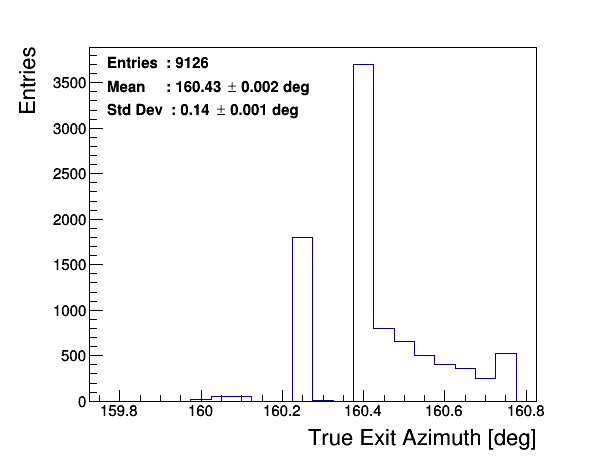

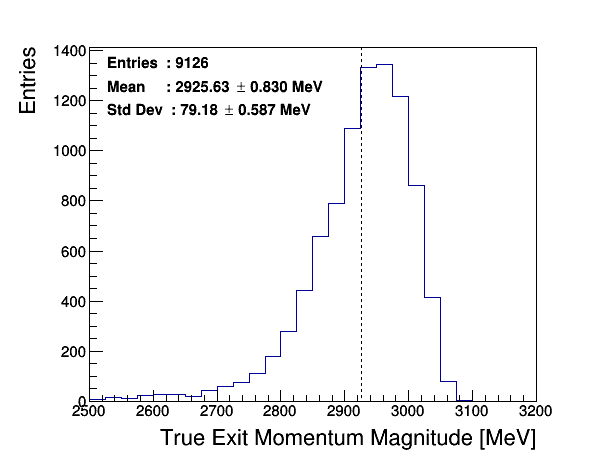

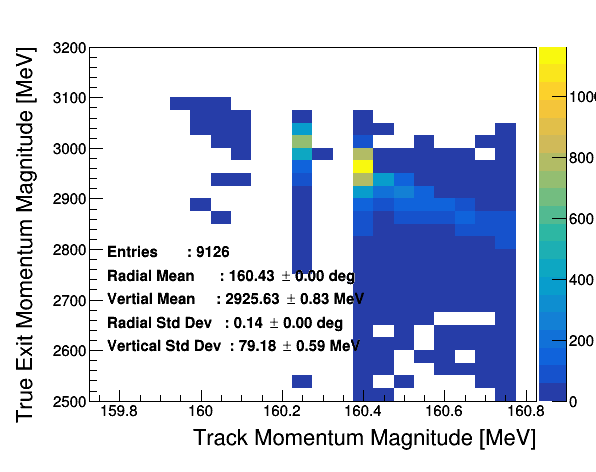

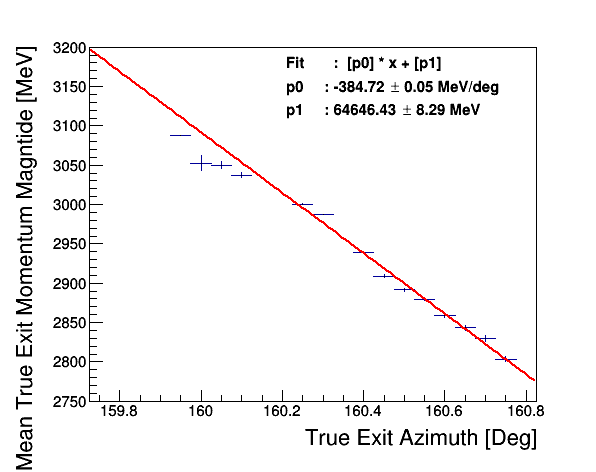

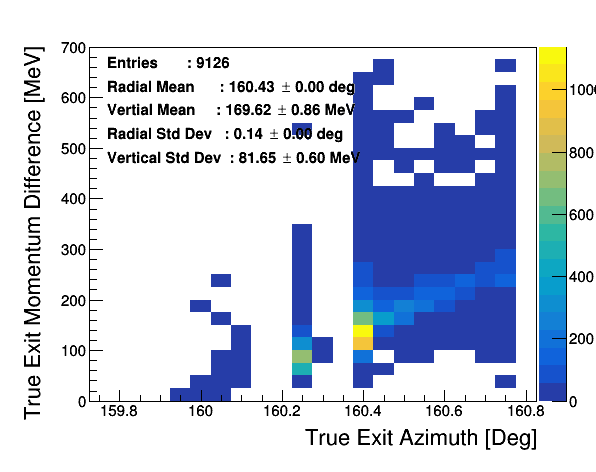

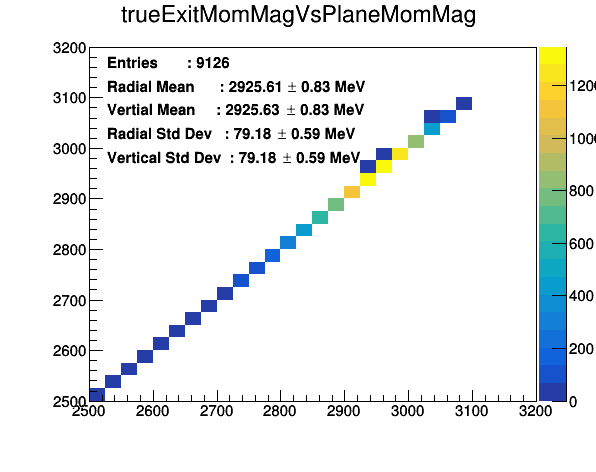

In [536]:
ROOT.gStyle.SetOptFit(0)
ROOT.gStyle.SetOptStat(0)
lowAz = 159.725
highAz = 160.825
nBinsAz = 22

lowMom = 2500
highMom = 3200
nBinsMom = 28

lowMomDiff = 0
highMomDiff = 700
nBinsMomDiff = 28

h_trueExitAz = ROOT.TH1F("h_trueExitAx","trueExitAz",nBinsAz,lowAz,highAz)
h_trueExitMomMag = ROOT.TH1F("h_trueExitMomMag","trueExitMomMag",nBinsMom,lowMom,highMom)
h_trueExitMomMagVsAz = ROOT.TH2F("h_trueExitMomMagVsAz","trueExitMomMagVsAz",nBinsAz,lowAz,highAz,nBinsMom,lowMom,highMom)
h_trueExitMomDiffVsAz = ROOT.TH2F("h_trueExitMomDiffVsAz","trueExitMomDiffVsAz",nBinsAz,lowAz,highAz,nBinsMomDiff,lowMomDiff,highMomDiff)
h_trueExitMomMagVsPlaneMomMag = ROOT.TH2F("h_trueExitMomMagVsPlaneMomMag","trueExitMomMagVsPlaneMomMag",nBinsMom,lowMom,highMom,nBinsMom,lowMom,highMom)


trueExitAzimuths = dfCut.loc[(dfCut['planeAzimuth']==160.3) & (dfCut['ghostExitAzimuth'].notnull())]['ghostExitAzimuth'].values
trueExitMomMag = dfCut.loc[(dfCut['planeAzimuth']==160.3) & (dfCut['ghostExitAzimuth'].notnull())]['ghostExitMomMag'].values
trueExitMomDiff = dfCut.loc[(dfCut['planeAzimuth']==160.3) & (dfCut['ghostExitAzimuth'].notnull())]['ghostExitMomChange'].values
trackMomMag = dfCut.loc[(dfCut['planeAzimuth']==160.3) & (dfCut['ghostExitAzimuth'].notnull())]['planeMomMag'].values


for i in range(0,len(trueExitAzimuths)) :
        if ((not math.isnan(trueExitAzimuths[i]))) :
            h_trueExitAz.Fill(trueExitAzimuths[i])
            h_trueExitMomMag.Fill(trueExitMomMag[i])
            h_trueExitMomMagVsAz.Fill(trueExitAzimuths[i],trueExitMomMag[i])
            h_trueExitMomDiffVsAz.Fill(trueExitAzimuths[i],trueExitMomDiff[i])
            h_trueExitMomMagVsPlaneMomMag.Fill(trackMomMag[i],trueExitMomMag[i])
            #print(trueExitMomDiff[i])
            
#plot the histograms
c_trueExitAzimuth = ROOT.TCanvas("c_trueExitAzimuth","True Exit Azimuth",600,500)
h_trueExitAz.Draw()
#c_trueExitAzimuth.SetLogy()
latex = ROOT.TLatex();
latex.SetTextSize(0.035);
latex.SetTextAlign(13);
latex.DrawLatexNDC(.18,.88,"Entries  : " +  "{:.0f}".format(h_trueExitAz.GetEntries()));
latex.DrawLatexNDC(.18,.83,"Mean     : " +  "{:.2f}".format(h_trueExitAz.GetMean()) + " #pm " + "{:.3f}".format(h_trueExitAz.GetMeanError()) + " deg");
latex.DrawLatexNDC(.18,.78,"Std Dev  : " +  "{:.2f}".format(h_trueExitAz.GetRMS()) + " #pm " + "{:.3f}".format(h_trueExitAz.GetRMSError()) + " deg");
h_trueExitAz.GetXaxis().SetTitleSize(0.05)
h_trueExitAz.GetYaxis().SetTitleSize(0.05)
c_trueExitAzimuth.SetLeftMargin(0.15)
c_trueExitAzimuth.SetBottomMargin(0.15)
c_trueExitAzimuth.Draw()
lih = ROOT.TLine(h_trueExitAz.GetMean(),0,h_trueExitAz.GetMean(),c_trueExitAzimuth.GetUymax()) 
lih.SetLineStyle(2)
lih.Draw()
h_trueExitAz.SetTitle(";True Exit Azimuth [deg];Entries")
c_trueExitAzimuth.SaveAs("Images/Individual/trueExitAzimuth.pdf")

c_trueExitMomMag = ROOT.TCanvas("c_trueExitMomMag","True Exit Mom Mag",600,500)
h_trueExitMomMag.Draw()
#c_trueExitAzimuth.SetLogy()
latex = ROOT.TLatex();
latex.SetTextSize(0.035);
latex.SetTextAlign(13);
latex.DrawLatexNDC(.18,.88,"Entries  : " +  "{:.0f}".format(h_trueExitMomMag.GetEntries()));
latex.DrawLatexNDC(.18,.83,"Mean     : " +  "{:.2f}".format(h_trueExitMomMag.GetMean()) + " #pm " + "{:.3f}".format(h_trueExitMomMag.GetMeanError()) + " MeV");
latex.DrawLatexNDC(.18,.78,"Std Dev  : " +  "{:.2f}".format(h_trueExitMomMag.GetRMS()) + " #pm " + "{:.3f}".format(h_trueExitMomMag.GetRMSError()) + " MeV");
h_trueExitMomMag.GetXaxis().SetTitleSize(0.05)
h_trueExitMomMag.GetYaxis().SetTitleSize(0.05)
c_trueExitMomMag.SetLeftMargin(0.15)
c_trueExitMomMag.SetBottomMargin(0.15)
c_trueExitMomMag.Draw()
lih = ROOT.TLine(h_trueExitMomMag.GetMean(),0,h_trueExitMomMag.GetMean(),c_trueExitMomMag.GetUymax()) 
lih.SetLineStyle(2)
lih.Draw()
h_trueExitMomMag.SetTitle(";True Exit Momentum Magnitude [MeV];Entries")
c_trueExitMomMag.SaveAs("Images/Individual/trueExitMomMag.pdf")

c_2D = ROOT.TCanvas("c_2D","2D",600,500)
h_trueExitMomMagVsAz.Draw("colz")
latex = ROOT.TLatex();
latex.SetTextSize(0.035);
latex.SetTextAlign(13);
latex.DrawLatexNDC(.18,.48,"Entries       : " +  "{:.0f}".format(h_trueExitMomMagVsAz.GetEntries()));
latex.DrawLatexNDC(.18,.43,"Radial Mean      : " +  "{:.2f}".format(h_trueExitMomMagVsAz.GetMean(1)) + " #pm " + "{:.2f}".format(h_trueExitMomMagVsAz.GetMeanError(1)) +" deg");
latex.DrawLatexNDC(.18,.38,"Vertial Mean     : " +  "{:.2f}".format(h_trueExitMomMagVsAz.GetMean(2)) + " #pm " + "{:.2f}".format(h_trueExitMomMagVsAz.GetMeanError(2)) +" MeV");
latex.DrawLatexNDC(.18,.33,"Radial Std Dev   : " +  "{:.2f}".format(h_trueExitMomMagVsAz.GetRMS(1)) + " #pm " + "{:.2f}".format(h_trueExitMomMagVsAz.GetRMSError(1)) + " deg");
latex.DrawLatexNDC(.18,.28,"Vertical Std Dev  : " +  "{:.2f}".format(h_trueExitMomMagVsAz.GetRMS(2)) + " #pm " + "{:.2f}".format(h_trueExitMomMagVsAz.GetRMSError(2)) + " MeV");
h_trueExitMomMagVsAz.GetXaxis().SetTitleSize(0.05)
h_trueExitMomMagVsAz.GetYaxis().SetTitleSize(0.05)
c_2D.SetLeftMargin(0.15)
c_2D.SetBottomMargin(0.15)
c_2D.Draw()
h_trueExitMomMagVsAz.SetTitle(";True Exit Azimuth [Deg];True Exit Momentum Magnitude [MeV]")
c_2D.SaveAs("Images/Individual/trueExitMomMagVsAz.pdf")

c_profile = ROOT.TCanvas("c_profile","profile",600,500)
h_trueExitMomMagVsAz_profile = h_trueExitMomMagVsAz.ProfileX()
h_trueExitMomMagVsAz_profile.Draw()
h_trueExitMomMagVsAz_profile.GetXaxis().SetTitleSize(0.05)
h_trueExitMomMagVsAz_profile.GetYaxis().SetTitleSize(0.05)
c_profile.SetLeftMargin(0.15)
c_profile.SetBottomMargin(0.15)
h_trueExitMomMagVsAz_profile.GetYaxis().SetRangeUser(2750,3200)
h_trueExitMomMagVsAz_profile.SetTitle(";True Exit Azimuth [Deg];Mean True Exit Momentum Magntide [MeV]")
f_line = ROOT.TF1("line","[0]*x+[1]")
f_line.SetParameters(-390,64000)
h_trueExitMomMagVsAz_profile.Fit(f_line)
fitFunc = h_trueExitMomMagVsAz_profile.GetFunction("line")
latex = ROOT.TLatex();
latex.SetTextSize(0.035);
latex.SetTextAlign(13);
latex.DrawLatexNDC(.48,.88,"Fit       : " + " [p0] * x + [p1]")
latex.DrawLatexNDC(.48,.83,"p0     : " +  "{:.2f}".format(fitFunc.GetParameter(0)) + " #pm " + "{:.2f}".format(fitFunc.GetParError(0)) +" MeV/deg");
latex.DrawLatexNDC(.48,.78,"p1     : " +  "{:.2f}".format(fitFunc.GetParameter(1)) + " #pm " + "{:.2f}".format(fitFunc.GetParError(1)) +" MeV");
c_profile.Draw()
c_profile.SaveAs("Images/Individual/trueExitMomDiffVsAz_profile.pdf")

c_2DDiff = ROOT.TCanvas("c_2D_Diff","2DDiff",600,500)
h_trueExitMomDiffVsAz.Draw("colz")
latex = ROOT.TLatex();
latex.SetTextSize(0.035);
latex.SetTextAlign(13);
latex.DrawLatexNDC(.18,.88,"Entries       : " +  "{:.0f}".format(h_trueExitMomDiffVsAz.GetEntries()));
latex.DrawLatexNDC(.18,.83,"Radial Mean      : " +  "{:.2f}".format(h_trueExitMomDiffVsAz.GetMean(1)) + " #pm " + "{:.2f}".format(h_trueExitMomDiffVsAz.GetMeanError(1)) +" deg");
latex.DrawLatexNDC(.18,.78,"Vertial Mean     : " +  "{:.2f}".format(h_trueExitMomDiffVsAz.GetMean(2)) + " #pm " + "{:.2f}".format(h_trueExitMomDiffVsAz.GetMeanError(2)) +" MeV");
latex.DrawLatexNDC(.18,.73,"Radial Std Dev   : " +  "{:.2f}".format(h_trueExitMomDiffVsAz.GetRMS(1)) + " #pm " + "{:.2f}".format(h_trueExitMomDiffVsAz.GetRMSError(1)) + " deg");
latex.DrawLatexNDC(.18,.68,"Vertical Std Dev  : " +  "{:.2f}".format(h_trueExitMomDiffVsAz.GetRMS(2)) + " #pm " + "{:.2f}".format(h_trueExitMomDiffVsAz.GetRMSError(2)) + " MeV");
h_trueExitMomDiffVsAz.GetXaxis().SetTitleSize(0.05)
h_trueExitMomDiffVsAz.GetYaxis().SetTitleSize(0.05)
c_2DDiff.SetLeftMargin(0.15)
c_2DDiff.SetBottomMargin(0.15)
c_2DDiff.Draw()
h_trueExitMomDiffVsAz.SetTitle(";True Exit Azimuth [Deg];True Exit Momentum Difference [MeV]")
c_2DDiff.SaveAs("Images/Individual/trueExitMomDiffVsAz.pdf")

c_2D_m = ROOT.TCanvas("c_2D_m","2D_m",600,500)
h_trueExitMomMagVsPlaneMomMag.Draw("colz")
latex = ROOT.TLatex();
latex.SetTextSize(0.035);
latex.SetTextAlign(13);
latex.DrawLatexNDC(.18,.88,"Entries       : " +  "{:.0f}".format(h_trueExitMomMagVsPlaneMomMag.GetEntries()));
latex.DrawLatexNDC(.18,.83,"Radial Mean      : " +  "{:.2f}".format(h_trueExitMomMagVsPlaneMomMag.GetMean(1)) + " #pm " + "{:.2f}".format(h_trueExitMomMagVsPlaneMomMag.GetMeanError(1)) +" MeV");
latex.DrawLatexNDC(.18,.78,"Vertial Mean     : " +  "{:.2f}".format(h_trueExitMomMagVsPlaneMomMag.GetMean(2)) + " #pm " + "{:.2f}".format(h_trueExitMomMagVsPlaneMomMag.GetMeanError(2)) +" MeV");
latex.DrawLatexNDC(.18,.73,"Radial Std Dev   : " +  "{:.2f}".format(h_trueExitMomMagVsPlaneMomMag.GetRMS(1)) + " #pm " + "{:.2f}".format(h_trueExitMomMagVsPlaneMomMag.GetRMSError(1)) + " MeV");
latex.DrawLatexNDC(.18,.68,"Vertical Std Dev  : " +  "{:.2f}".format(h_trueExitMomMagVsPlaneMomMag.GetRMS(2)) + " #pm " + "{:.2f}".format(h_trueExitMomMagVsPlaneMomMag.GetRMSError(2)) + " MeV");
h_trueExitMomMagVsPlaneMomMag.GetXaxis().SetTitleSize(0.05)
h_trueExitMomMagVsPlaneMomMag.GetYaxis().SetTitleSize(0.05)
c_2D_m.SetLeftMargin(0.15)
c_2D_m.SetBottomMargin(0.15)
c_2D_m.Draw()
h_trueExitMomMagVsAz.SetTitle(";Track Momentum Magnitude [MeV];True Exit Momentum Magnitude [MeV]")
c_2D_m.SaveAs("Images/Individual/trueExitMomMagVsPlaneMomAg.pdf")

In [ ]:
#plot the target (and some trajectories)
target1 = [[(7112+0.5)*np.sin(160.3*np.pi/180) + 50*np.sin((160.3-90)*np.pi/180),(7112+0.5)*np.sin(160.3*np.pi/180) - 50*np.sin((160.3-90)*np.pi/180),(7112-0.5)*np.sin(160.3*np.pi/180) - 50*np.sin((160.3-90)*np.pi/180),(7112-0.5)*np.sin(160.3*np.pi/180) + 50*np.sin((160.3-90)*np.pi/180),(7112+0.5)*np.sin(160.3*np.pi/180) + 50*np.sin((160.3-90)*np.pi/180)],
          [(7112+0.5)*np.cos(160.3*np.pi/180) + 50*np.cos((160.3-90)*np.pi/180),(7112+0.5)*np.cos(160.3*np.pi/180) - 50*np.cos((160.3-90)*np.pi/180),(7112-0.5)*np.cos(160.3*np.pi/180) - 50*np.cos((160.3-90)*np.pi/180),(7112-0.5)*np.cos(160.3*np.pi/180) + 50*np.cos((160.3-90)*np.pi/180),(7112+0.5)*np.cos(160.3*np.pi/180) + 50*np.cos((160.3-90)*np.pi/180)]]
target2 = [[(7112+0.5+20)*np.sin(160.3*np.pi/180) + 50*np.sin((160.3-90)*np.pi/180),(7112+0.5+20)*np.sin(160.3*np.pi/180) - 50*np.sin((160.3-90)*np.pi/180),(7112-0.5+20)*np.sin(160.3*np.pi/180) - 50*np.sin((160.3-90)*np.pi/180),(7112-0.5+20)*np.sin(160.3*np.pi/180) + 50*np.sin((160.3-90)*np.pi/180),(7112+0.5+20)*np.sin(160.3*np.pi/180) + 50*np.sin((160.3-90)*np.pi/180)],
          [(7112+0.5+20)*np.cos(160.3*np.pi/180) + 50*np.cos((160.3-90)*np.pi/180),(7112+0.5+20)*np.cos(160.3*np.pi/180) - 50*np.cos((160.3-90)*np.pi/180),(7112-0.5+20)*np.cos(160.3*np.pi/180) - 50*np.cos((160.3-90)*np.pi/180),(7112-0.5+20)*np.cos(160.3*np.pi/180) + 50*np.cos((160.3-90)*np.pi/180),(7112+0.5+20)*np.cos(160.3*np.pi/180) + 50*np.cos((160.3-90)*np.pi/180)]]
target3 = [[(7112+0.5-20)*np.sin(160.3*np.pi/180) + 50*np.sin((160.3-90)*np.pi/180),(7112+0.5-20)*np.sin(160.3*np.pi/180) - 50*np.sin((160.3-90)*np.pi/180),(7112-0.5-20)*np.sin(160.3*np.pi/180) - 50*np.sin((160.3-90)*np.pi/180),(7112-0.5-20)*np.sin(160.3*np.pi/180) + 50*np.sin((160.3-90)*np.pi/180),(7112+0.5-20)*np.sin(160.3*np.pi/180) + 50*np.sin((160.3-90)*np.pi/180)],
          [(7112+0.5-20)*np.cos(160.3*np.pi/180) + 50*np.cos((160.3-90)*np.pi/180),(7112+0.5-20)*np.cos(160.3*np.pi/180) - 50*np.cos((160.3-90)*np.pi/180),(7112-0.5-20)*np.cos(160.3*np.pi/180) - 50*np.cos((160.3-90)*np.pi/180),(7112-0.5-20)*np.cos(160.3*np.pi/180) + 50*np.cos((160.3-90)*np.pi/180),(7112+0.5-20)*np.cos(160.3*np.pi/180) + 50*np.cos((160.3-90)*np.pi/180)]]

print(0.5*(np.linalg.norm([target1[0][1],target1[1][1]]) + np.linalg.norm([target1[0][2],target1[1][2]])))

uniqueTracks = dfCut.TrackNumber.unique()
uniqueAzimuths = dfCut.planeAzimuth.unique()
fig, ax = plt.subplots(figsize=(12, 8))
plt.ylim(-6750,-6640)
plt.xlim(2300,2500)
plt.xlabel("global z position [mm]",size=20)
plt.ylabel("global x position [mm]",size=20)
numTracks = 0
for track in uniqueTracks :
    numTracks = numTracks + 1
    if (numTracks > 100) :
        break
    if (numTracks <10) :
        plt.plot(dfCut.loc[dfCut['TrackNumber']==track]['ghostPlaneZPos'].values,dfCut.loc[dfCut['TrackNumber']==track]['ghostPlaneXPos'].values,'bo')
        plt.plot(dfCut.loc[dfCut['TrackNumber']==track]['planeZPos'].values,dfCut.loc[dfCut['TrackNumber']==track]['planeXPos'].values,'ro')

plt.plot(target1[0],target1[1],'xg-')
plt.plot(target2[0],target2[1],'xg-')
plt.plot(target3[0],target3[1],'xg-')


In [ ]:
# fig,ax = plt.subplots()
# for az in azimuths :
#     plt.hist(dfCut.loc[dfCut['planeAzimuth']==az]['ghostPlaneMomMag'].values)
#     plt.xlim([2500,3150])
#     plt.show();

a = dfCut.loc[dfCut["TrackNumber"]==dfCut.TrackNumber.unique()[5]][['planeAzimuth','ghostPlaneMomMag']].values
b = np.where(np.abs(a[:,1] - a[30,1]) < 0.00001)
print(a[:,0][np.min(b[0])])
print(a[:,1][np.min(b[0])])
print(a[0,1] - a[:,1][np.min(b[0])])

In [ ]:
i=1
print(dfCut['planeAzimuth'].values[i])
print(ComputeAzimuth(dfCut['planeXPos'].values[i],dfCut['planeZPos'].values[i])*180.0/np.pi)
print(dfCut['planeActualAzimuth'].values[i])
print(ComputeAzimuth(dfCut['ghostPlaneXPos'].values[i],dfCut['ghostPlaneZPos'].values[i])*180.0/np.pi)
print(dfCut['ghostPlaneActualAzimuth'].values[i])
print(ComputeAzimuth(dfCut['planeXPos'].values[i],dfCut['planeZPos'].values[i])*180.0/np.pi-ComputeAzimuth(dfCut['ghostPlaneXPos'].values[i],dfCut['ghostPlaneZPos'].values[i])*180.0/np.pi)

In [ ]:
##### plot the number of of tracks that hit each azimuth plane
azimuths = np.arange(0,31)*0.05+159.5;
nTracks = []
for az in azimuths :
    nTracks.append((len(dfCut.loc[dfCut['planeAzimuth'] == az].TrackNumber.unique())))
plt.plot(azimuths,nTracks)
plt.xlabel("Azimuth [Deg]");
plt.ylabel("Tracks");

In [ ]:
a=dfCut.loc[(dfCut["planeAzimuth"]==160.7) & (dfCut["planeMomMag"]<3500) & (dfCut["ghostPlaneRadMom"].notnull())]
# a["ghostPlaneMomMag"].hist(bins=50)
# plt.show()
a["planeMomMag"].hist(bins=50)
plt.show()
plt.hist2d(a["planeRadPos"].values,a["planeVertPos"].values,[100,100]);
plt.xlim([-60,60])
plt.ylim([-60,60])
plt.show()
plt.hist2d(a["ghostPlaneRadPos"].values,a["ghostPlaneVertPos"].values,[100,100]);
plt.xlim([-60,60])
plt.ylim([-60,60])
plt.show()
plt.hist(a["planeRadPos"].values-a["ghostPlaneRadPos"].values,50);
plt.show()
plt.hist(a["planeVertPos"].values-a["ghostPlaneVertPos"].values,50);
plt.show()

In [ ]:
def passesAzimuthMomentumMap(azimuth, momentum) :
    p0 = -384.72
    p1= 64646.47

    momBinWidth = 19.2360000000001
    momLow = np.floor(momentum/momBinWidth)*momBinWidth
    momHigh = np.floor(momentum/momBinWidth)*momBinWidth + momBinWidth
    azHigh = (1/p0)*(momLow - p1)
    azLow = (1/p0)*(momHigh - p1)
    print(azHigh-azLow)

    if ((azimuth >= azLow) and (azimuth < azHigh)) :
        return True
    else :
        return False
passesAzimuthMomentumMap(160.2,500)

In [ ]:
azimuths = np.arange(0,23)*0.05+159.9

 FCN=5.60462 FROM MIGRAD    STATUS=CONVERGED     309 CALLS         310 TOTAL
                     EDM=4.98431e-09    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           3.87504e-01   2.89810e-02   4.32210e-06  -7.91821e-03
   2  p1           1.59812e+02   3.91975e-02   7.62043e-05   1.53390e-02
   3  p2           5.20595e-01   7.06990e-03   1.51779e-06  -4.32308e-02
 FCN=32.0508 FROM MIGRAD    STATUS=CONVERGED     162 CALLS         163 TOTAL
                     EDM=9.47862e-10    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           1.01326e+00   1.90859e-02   2.99301e-05  -3.66532e-03
   2  p1           1.60236e+02   2.59756e-03   7.64063e-05   8.97594e-03
   3  p2           3.36081e-01   

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_rad
Info in <TCanvas::Print>: png file Images/Rad/RadPos_160.0_deg.png has been created
Info in <TCanvas::Print>: png file Images/Rad/RadPos_160.05_deg.png has been created
Info in <TCanvas::Print>: png file Images/Rad/RadPos_160.1_deg.png has been created
Info in <TCanvas::Print>: png file Images/Rad/RadPos_160.15_deg.png has been created
Info in <TCanvas::Print>: png file Images/Rad/RadPos_160.2_deg.png has been created
Info in <TCanvas::Print>: png file Images/Rad/RadPos_160.25_deg.png has been created
Info in <TCanvas::Print>: png file Images/Rad/RadPos_160.3_deg.png has been created
Info in <TCanvas::Print>: png file Images/Rad/RadPos_160.35_deg.png has been created
Info in <TCanvas::Print>: png file Images/Rad/RadPos_160.4_deg.png has been created
Info in <TCanvas::Print>: png file Images/Rad/RadPos_160.45_deg.png has been created
Info in <TCanvas::Print>: png file Images/Rad/RadPos_160.5_deg.png has been create

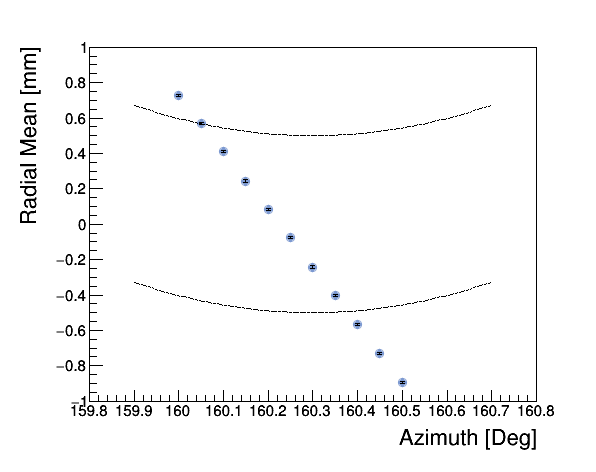

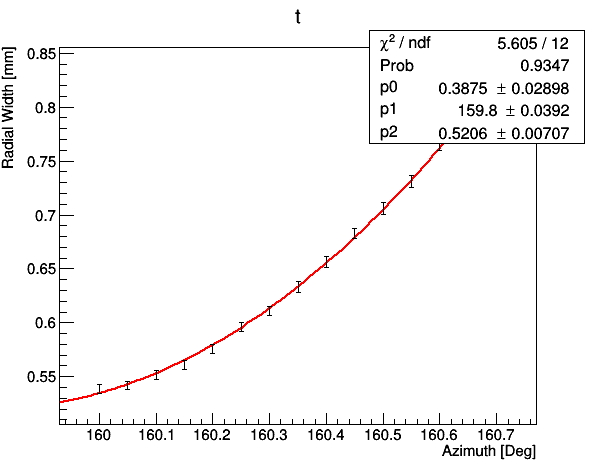

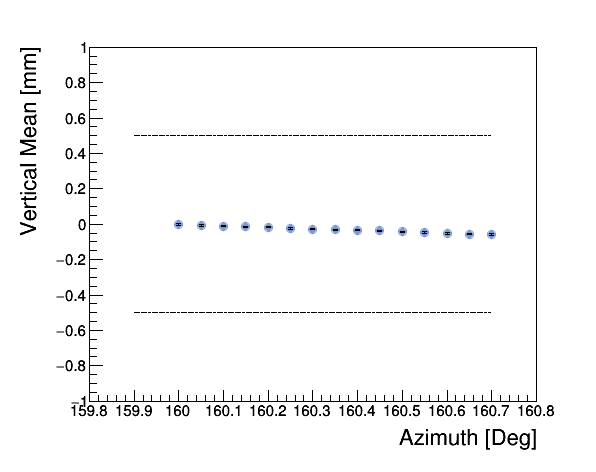

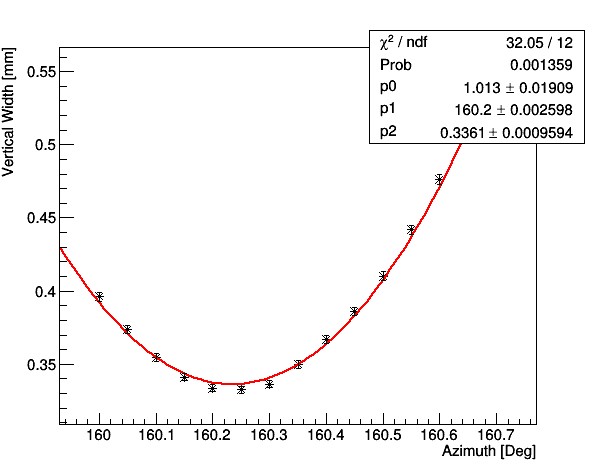

In [539]:
# del h_rads
# del h_verts
h_rads = {}
h_verts = {}
h_2Ds = {}
low = -45
high = 45
nBins = 180
azimuths = [160.0,160.05,160.10,160.15,160.20,160.25,160.30,160.35,160.40,160.45,160.50,160.55,160.60,160.65,160.70]#np.arange(0,23)*0.05+159.9
#azimuths = [160.0,160.10,160.20,160.30,160.40,160.50,160.60,160.70]#np.arange(0,23)*0.05+159.9

useAzimuthMomentumMap = 0
def passesAzimuthMomentumMap(azimuth, momentum) :
    p0 = -384.72
    p1= 64646.47

    momBinWidth = 19.2360000000001
    momLow = np.floor(momentum/momBinWidth)*momBinWidth
    momHigh = np.floor(momentum/momBinWidth)*momBinWidth + momBinWidth
    azHigh = (1/p0)*(momLow - p1)
    azLow = (1/p0)*(momHigh - p1)

    if ((azimuth >= azLow) and (azimuth < azHigh)) :
        return True
    else :
        return False
    
#initialize the histograms
for az in azimuths :
    h_rads["azimuth_"+str(az)] = ROOT.TH1F("radPos"+str(az),"radPos"+str(az),nBins,low,high)
    h_verts["azimuth_"+str(az)] = ROOT.TH1F("vertPos"+str(az),"vertPos"+str(az),nBins,low,high)
    h_2Ds["azimuth_"+str(az)] = ROOT.TH2F("2D"+str(az),"2D"+str(az),nBins,low,high,nBins,low,high)
    
#fill the histograms   
for az in azimuths :
#     radPositions = dfCut.loc[(dfCut['planeAzimuth']==az) & (dfCut['ghostExitAzimuth']==az) & (dfCut['ghostPlaneRadPos'].notnull())]['ghostPlaneRadPos'].values
#     vertPositions = dfCut.loc[(dfCut['planeAzimuth']==az) & (dfCut['ghostExitAzimuth']==az) & (dfCut['ghostPlaneVertPos'].notnull())]['ghostPlaneVertPos'].values
#     momMags = dfCut.loc[(dfCut['planeAzimuth']==az) & (dfCut['ghostExitAzimuth']==az) & (dfCut['ghostPlaneMomMag'].notnull())]['ghostPlaneMomMag'].values

    radPositions = dfCut.loc[(dfCut['planeAzimuth']==az) & (dfCut['planeRadPos'].notnull())]['planeRadPos'].values
    vertPositions = dfCut.loc[(dfCut['planeAzimuth']==az)& (dfCut['planeRadPos'].notnull())]['planeVertPos'].values
    momMags = dfCut.loc[(dfCut['planeAzimuth']==az) & (dfCut['planeRadPos'].notnull())]['planeMomMag'].values

#     radPositions = dfCut.loc[(dfCut['planeAzimuth']==az) & (dfCut['ghostPlaneRadPos'].notnull())]['ghostPlaneRadPos'].values
#     vertPositions = dfCut.loc[(dfCut['planeAzimuth']==az)& (dfCut['ghostPlaneRadPos'].notnull())]['ghostPlaneVertPos'].values
#     momMags = dfCut.loc[(dfCut['planeAzimuth']==az) & (dfCut['ghostPlaneRadPos'].notnull())]['ghostPlaneMomMag'].values

    
    for i in range(0,len(radPositions)) :
        if ((not math.isnan(radPositions[i])) and (not math.isnan(vertPositions[i]))) :
            
            # if this muon has theorrect momentum
            if (useAzimuthMomentumMap) :
                
                if (not passesAzimuthMomentumMap(az,momMags[i])) :
                    continue
            
            h_rads["azimuth_"+str(az)].Fill(radPositions[i])
            h_verts["azimuth_"+str(az)].Fill(vertPositions[i])
            h_2Ds["azimuth_"+str(az)].Fill(radPositions[i],vertPositions[i])
        
#plot the histograms
c_rad = ROOT.TCanvas("c_rad","Radial Position",600,400)
for az in azimuths :
    h_rads["azimuth_"+str(az)].Draw()
    #c_rad.Draw()
    c_rad.SaveAs("Images/Rad/RadPos_"+str(az)+"_deg.png")

c_vert = ROOT.TCanvas("c_vert","Vertical Position",600,400)
for az in azimuths :
    h_verts["azimuth_"+str(az)].Draw()
    #c_vert.Draw()
    c_vert.SaveAs("Images/Vert/VertPos_"+str(az)+"_deg.png")

c_2D = ROOT.TCanvas("c_2D","2D",600,400)
for az in azimuths :
    h_2Ds["azimuth_"+str(az)].Draw("colz")
    #c_vert.Draw()
    c_2D.SaveAs("Images/2D/2D"+str(az)+"_deg.png")

#Get mean and width around each "target"
#radial
#mean
radMeanNegative20 = {}
radMean0 = {}
radMeanPositive20 = {}
#width
radWidthNegative20 = {}
radWidth0 = {}
radWidthPositive20 = {}
#vertical
#mean
vertMeanNegative20 = {}
vertMean0 = {}
vertMeanPositive20 = {}
#width
vertWidthNegative20 = {}
vertWidth0 = {}
vertWidthPositive20 = {}

width = 10
for az in azimuths :
    #rad
    h_rads["azimuth_"+str(az)].GetXaxis().SetRangeUser(-20-width/2.0,-20+width/2.0)
    radMeanNegative20["azimuth_"+str(az)] = [h_rads["azimuth_"+str(az)].GetMean(),h_rads["azimuth_"+str(az)].GetMeanError()]
    radWidthNegative20["azimuth_"+str(az)] = [h_rads["azimuth_"+str(az)].GetRMS(),h_rads["azimuth_"+str(az)].GetRMSError()]
    
    h_rads["azimuth_"+str(az)].GetXaxis().SetRangeUser(-width/2.0,width/2.0)
    radMean0["azimuth_"+str(az)] = [h_rads["azimuth_"+str(az)].GetMean(),h_rads["azimuth_"+str(az)].GetMeanError()]
    radWidth0["azimuth_"+str(az)] = [h_rads["azimuth_"+str(az)].GetRMS(),h_rads["azimuth_"+str(az)].GetRMSError()]
    
    h_rads["azimuth_"+str(az)].GetXaxis().SetRangeUser(20-width/2.0,20+width/2.0)
    radMeanPositive20["azimuth_"+str(az)] = [h_rads["azimuth_"+str(az)].GetMean(),h_rads["azimuth_"+str(az)].GetMeanError()]
    radWidthPositive20["azimuth_"+str(az)] = [h_rads["azimuth_"+str(az)].GetRMS(),h_rads["azimuth_"+str(az)].GetRMSError()]
    
    #vert
    h_verts["azimuth_"+str(az)].GetXaxis().SetRangeUser(-20-width/2.0,-20+width/2.0)
    vertMeanNegative20["azimuth_"+str(az)] = [h_verts["azimuth_"+str(az)].GetMean(),h_verts["azimuth_"+str(az)].GetMeanError()]
    vertWidthNegative20["azimuth_"+str(az)] = [h_verts["azimuth_"+str(az)].GetRMS(),h_verts["azimuth_"+str(az)].GetRMSError()]

    h_verts["azimuth_"+str(az)].GetXaxis().SetRangeUser(-width/2.0,width/2.0)
    vertMean0["azimuth_"+str(az)] = [h_verts["azimuth_"+str(az)].GetMean(),h_verts["azimuth_"+str(az)].GetMeanError()]
    vertWidth0["azimuth_"+str(az)] = [h_verts["azimuth_"+str(az)].GetRMS(),h_verts["azimuth_"+str(az)].GetRMSError()]
    
    h_verts["azimuth_"+str(az)].GetXaxis().SetRangeUser(20-width/2.0,20+width/2.0)
    vertMeanPositive20["azimuth_"+str(az)] = [h_verts["azimuth_"+str(az)].GetMean(),h_verts["azimuth_"+str(az)].GetMeanError()]
    vertWidthPositive20["azimuth_"+str(az)] = [h_verts["azimuth_"+str(az)].GetRMS(),h_verts["azimuth_"+str(az)].GetRMSError()]

#Initalize graphs

#radial
#mean
g_radMeanNegative20 = ROOT.TGraphErrors()
g_radMeanNegative20.SetTitle("-20 mm target;Azimuth [Deg];Radial Mean [mm]")
g_radMean0 = ROOT.TGraphErrors()
g_radMean0.SetTitle(";Azimuth [Deg];Radial Mean [mm]")
g_radMeanPositive20 = ROOT.TGraphErrors()
g_radMeanPositive20.SetTitle("20 mm target;Azimuth [Deg];Radial Mean [mm]")
#width
g_radWidthNegative20 = ROOT.TGraphErrors()
g_radWidthNegative20.SetTitle("-20 mm target;Azimuth [Deg];Radial Width [mm]")
g_radWidth0 = ROOT.TGraphErrors()
g_radWidth0.SetTitle("t;Azimuth [Deg];Radial Width [mm]")
g_radWidthPositive20 = ROOT.TGraphErrors()
g_radWidthPositive20.SetTitle("20 mm target;Azimuth [Deg];Radial Width [mm]")


#vertical
#mean
g_vertMeanNegative20 = ROOT.TGraphErrors()
g_vertMeanNegative20.SetTitle("-20 mm target;Azimuth [Deg];Vertical Mean [mm]")
g_vertMean0 = ROOT.TGraphErrors()
g_vertMean0.SetTitle(";Azimuth [Deg];Vertical Mean [mm]")
g_vertMeanPositive20 = ROOT.TGraphErrors()
g_vertMeanPositive20.SetTitle("20 mm target;Azimuth [Deg];Vertical Mean [mm]")
#width
g_vertWidthNegative20 = ROOT.TGraphErrors()
g_vertWidthNegative20.SetTitle("-20 mm target;Azimuth [Deg];Vertical Width [mm]")
g_vertWidth0 = ROOT.TGraphErrors()
g_vertWidth0.SetTitle(";Azimuth [Deg];Vertical Width [mm]")
g_vertWidthPositive20 = ROOT.TGraphErrors()
g_vertWidthPositive20.SetTitle("20 mm target;Azimuth [Deg];Vertical Width [mm]")

for az in azimuths :
    #radial
    #mean
    g_radMeanNegative20.SetPoint(g_radMeanNegative20.GetN(),az,radMeanNegative20["azimuth_"+str(az)][0])
    g_radMeanNegative20.SetPointError(g_radMeanNegative20.GetN()-1,0,radMeanNegative20["azimuth_"+str(az)][1])

    g_radMean0.SetPoint(g_radMean0.GetN(),az,radMean0["azimuth_"+str(az)][0])
    g_radMean0.SetPointError(g_radMean0.GetN()-1,0,radMean0["azimuth_"+str(az)][1])
    
    g_radMeanPositive20.SetPoint(g_radMeanPositive20.GetN(),az,radMeanPositive20["azimuth_"+str(az)][0])
    g_radMeanPositive20.SetPointError(g_radMeanPositive20.GetN()-1,0,radMeanPositive20["azimuth_"+str(az)][1])
    
    #width
    g_radWidthNegative20.SetPoint(g_radWidthNegative20.GetN(),az,radWidthNegative20["azimuth_"+str(az)][0])
    g_radWidthNegative20.SetPointError(g_radWidthNegative20.GetN()-1,0,radWidthNegative20["azimuth_"+str(az)][1])

    g_radWidth0.SetPoint(g_radWidth0.GetN(),az,radWidth0["azimuth_"+str(az)][0])
    g_radWidth0.SetPointError(g_radWidth0.GetN()-1,0,radWidth0["azimuth_"+str(az)][1])
    
    g_radWidthPositive20.SetPoint(g_radWidthPositive20.GetN(),az,radWidthPositive20["azimuth_"+str(az)][0])
    g_radWidthPositive20.SetPointError(g_radWidthPositive20.GetN()-1,0,radWidthPositive20["azimuth_"+str(az)][1])
       
    #vertical  
    #mean
    g_vertMeanNegative20.SetPoint(g_vertMeanNegative20.GetN(),az,vertMeanNegative20["azimuth_"+str(az)][0])
    g_vertMeanNegative20.SetPointError(g_vertMeanNegative20.GetN()-1,0,vertMeanNegative20["azimuth_"+str(az)][1])

    g_vertMean0.SetPoint(g_vertMean0.GetN(),az,vertMean0["azimuth_"+str(az)][0])
    g_vertMean0.SetPointError(g_vertMean0.GetN()-1,0,vertMean0["azimuth_"+str(az)][1])
    
    g_vertMeanPositive20.SetPoint(g_vertMeanPositive20.GetN(),az,vertMeanPositive20["azimuth_"+str(az)][0])
    g_vertMeanPositive20.SetPointError(g_vertMeanPositive20.GetN()-1,0,vertMeanPositive20["azimuth_"+str(az)][1])
    #width
    g_vertWidthNegative20.SetPoint(g_vertWidthNegative20.GetN(),az,vertWidthNegative20["azimuth_"+str(az)][0])
    g_vertWidthNegative20.SetPointError(g_vertWidthNegative20.GetN()-1,0,vertWidthNegative20["azimuth_"+str(az)][1])

    g_vertWidth0.SetPoint(g_vertWidth0.GetN(),az,vertWidth0["azimuth_"+str(az)][0])
    g_vertWidth0.SetPointError(g_vertWidth0.GetN()-1,0,vertWidth0["azimuth_"+str(az)][1])
    
    g_vertWidthPositive20.SetPoint(g_vertWidthPositive20.GetN(),az,vertWidthPositive20["azimuth_"+str(az)][0])
    g_vertWidthPositive20.SetPointError(g_vertWidthPositive20.GetN()-1,0,vertWidthPositive20["azimuth_"+str(az)][1])    

#target locations
alpha=160.3
R0 = 7112
dr = 0.5
g_targetInnerEdge = ROOT.TGraphErrors() #radial
g_targetOuterEdge = ROOT.TGraphErrors() #radial
g_targetLowerEdge = ROOT.TGraphErrors() #vertical
g_targetUpperEdge = ROOT.TGraphErrors() #vertical
for az in np.linspace(159.9,160.7,100) :
    zGlobalInner = (R0-dr)*np.sin(alpha) + (R0-dr)*np.tan((az-alpha)*np.pi/180)*np.sin(alpha-np.pi/2.0)
    xGlobalInner = (R0-dr)*np.cos(alpha) + (R0-dr)*np.tan((az-alpha)*np.pi/180)*np.cos(alpha-np.pi/2.0)
    g_targetInnerEdge.SetPoint(g_targetInnerEdge.GetN(),az,np.linalg.norm([zGlobalInner,xGlobalInner])-7112)
    
    zGlobalOuter = (R0+dr)*np.sin(alpha) + (R0+dr)*np.tan((az-alpha)*np.pi/180)*np.sin(alpha-np.pi/2.0)
    xGlobalOuter = (R0+dr)*np.cos(alpha) + (R0+dr)*np.tan((az-alpha)*np.pi/180)*np.cos(alpha-np.pi/2.0)
    g_targetOuterEdge.SetPoint(g_targetOuterEdge.GetN(),az,np.linalg.norm([zGlobalOuter,xGlobalOuter])-7112)
    
    g_targetLowerEdge.SetPoint(g_targetLowerEdge.GetN(),az,-dr)
    g_targetUpperEdge.SetPoint(g_targetUpperEdge.GetN(),az,dr)

   
    
#Fit functions and settings
ROOT.gStyle.SetOptFit(1111)
ROOT.gStyle.SetOptStat(2211)
f_line = ROOT.TF1("line","[0]*x+[1]")
f_line.SetParameters(-2.5,400)
f_parabola = ROOT.TF1("parabola","[0]*(x-[1])*(x-[1])+[2]")
f_parabola.SetParameters(1,160,-1)

#radial
#mean
# c_radMeanNegative20 = ROOT.TCanvas("c_radMeanNegative20","Radial Mean",600,400)
# g_radMeanNegative20.Draw("AP*")
# g_radMeanNegative20.Fit("line")
# g_radMeanNegative20.GetYaxis().SetRangeUser(-22,-18)
# c_radMeanNegative20.Draw()

c_radMean0 = ROOT.TCanvas("c_radMean0","Radial Mean",600,500)
g_radMean0.Draw("AP")
g_radMean0.SetMarkerStyle(8)
g_radMean0.SetMarkerColor(38)
#g_radMean0.Fit("line")
g_targetInnerEdge.SetLineStyle(2)
g_targetOuterEdge.SetLineStyle(2)
g_targetInnerEdge.Draw('SAME')
g_targetOuterEdge.Draw('SAME')
g_radMean0.GetXaxis().SetTitleSize(0.05)
g_radMean0.GetYaxis().SetTitleSize(0.05)
c_radMean0.SetLeftMargin(0.15)
c_radMean0.SetBottomMargin(0.15)
g_radMean0.GetYaxis().SetRangeUser(-1,1)
g_radMean0.GetXaxis().SetLimits(159.80,160.80)
c_radMean0.Draw()
c_radMean0.SaveAs("Images/vsAzimuth/radMean0.pdf")

# c_radMeanPositive20 = ROOT.TCanvas("c_radMeanPositive20","Radial Mean",600,400)
# g_radMeanPositive20.Draw("AP*")
# g_radMeanPositive20.Fit("line")
# g_radMeanPositive20.GetYaxis().SetRangeUser(18,22)
# c_radMeanPositive20.Draw()
#width
# c_radWidthNegative20 = ROOT.TCanvas("c_radWidthNegative20","Radial Width",600,400)
# g_radWidthNegative20.Draw("AP*")
# g_radWidthNegative20.Fit("parabola")
# c_radWidthNegative20.Draw()

c_radWidth0 = ROOT.TCanvas("c_radWidth0","Radial Width",600,500)
g_radWidth0.Draw("AP")
g_radWidth0.Fit("parabola")
c_radWidth0.Draw()

# c_radWidthPositive20 = ROOT.TCanvas("c_radWidthPositive20","Radial Width",600,400)
# g_radWidthPositive20.Draw("AP*")
# g_radWidthPositive20.Fit("parabola")
# c_radWidthPositive20.Draw()

#vertical
#mean
# c_vertMeanNegative20 = ROOT.TCanvas("c_vertMeanNegative20","Vertical Mean",600,400)
# g_vertMeanNegative20.Draw("AP*")
# g_vertMeanNegative20.Fit("line")
# g_vertMeanNegative20.GetYaxis().SetRangeUser(-22,-18)
# c_vertMeanNegative20.Draw()

c_vertMean0 = ROOT.TCanvas("c_vertMean0","Vertical Mean",600,500)
g_vertMean0.Draw("AP*")
#g_vertMean0.Fit('line')
g_vertMean0.SetMarkerStyle(8)
g_vertMean0.SetMarkerColor(38)
g_vertMean0.GetYaxis().SetRangeUser(-2,2)
g_targetLowerEdge.SetLineStyle(2)
g_targetUpperEdge.SetLineStyle(2)
g_targetLowerEdge.Draw('SAME')
g_targetUpperEdge.Draw('SAME')
g_vertMean0.GetXaxis().SetTitleSize(0.05)
g_vertMean0.GetYaxis().SetTitleSize(0.05)
c_vertMean0.SetLeftMargin(0.15)
c_vertMean0.SetBottomMargin(0.15)
g_vertMean0.GetYaxis().SetRangeUser(-1,1)
g_vertMean0.GetXaxis().SetLimits(159.80,160.80)
c_vertMean0.Draw()
c_vertMean0.SaveAs("Images/vsAzimuth/vertMean0.pdf")

# c_vertMeanPositive20 = ROOT.TCanvas("c_vertMeanPositive20","Vertical Mean",600,400)
# g_vertMeanPositive20.Draw("AP*")
# g_vertMeanPositive20.Fit('line')
# g_vertMeanPositive20.GetYaxis().SetRangeUser(18,22)
# c_vertMeanPositive20.Draw()
#width
# c_vertWidthNegative20 = ROOT.TCanvas("c_vertWidthNegative20","Vertical Width",600,400)
# g_vertWidthNegative20.Draw("AP*")
# g_vertWidthNegative20.Fit("parabola")
# c_vertWidthNegative20.Draw()

c_vertWidth0 = ROOT.TCanvas("c_vertWidth0","Vertical Width",600,500)
g_vertWidth0.Draw("AP*")
g_vertWidth0.Fit("parabola")
c_vertWidth0.Draw()

# c_vertWidthPositive20 = ROOT.TCanvas("c_vertWidthPositive20","Vertical Width",600,400)
# g_vertWidthPositive20.Draw("AP*")
# g_vertWidthPositive20.Fit("parabola")
# c_vertWidthPositive20.Draw()


In [ ]:
alpha=160.3
R0 = 7112
dr = 0.5
ls = np.linspace(-50,50,50)
ths = np.linspace(-0.007,0.007,50) + alpha
zTarget = (R0-dr)*np.sin(alpha) + ls*np.sin(alpha-np.pi/2.0)
xTarget = (R0-dr)*np.cos(alpha) + ls*np.cos(alpha-np.pi/2.0)
zCircle = (R0)*np.sin(ths)
xCircle = (R0)*np.cos(ths)
plt.plot(zTarget,xTarget,'xb-')
plt.plot(zCircle,xCircle,'xr-')